In [1]:
import os
import random
import json
import warnings
warnings.filterwarnings(action='ignore')

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import layers, models

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from utils import make_train_test, get_metrics, cross_validation

tf.random.Generator = None
tf.random.set_seed(42)
np.random.seed(42)

tf.version.VERSION

'2.3.0'

In [2]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices())

['/device:CPU:0']


In [3]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_real_estate/"
MAX_DIST = 5500
K_FOLDS = 55

In [4]:
structured_wiki_text = pd.read_csv(
    PATH + f"structured_wiki_doc2vec_features_{MAX_DIST}.csv")
print(structured_wiki_text.shape)
structured_wiki_text.head(10)

(9556, 565)


,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,vec_491,vec_492,vec_493,vec_494,vec_495,vec_496,vec_497,vec_498,vec_499,vec_500
0,362058,15212,126,47,12603,5329,10-27-2017,113000.0,69200,1.0,...,-42.060818,-51.523355,17.262004,-17.658364,-20.344189,-0.728078,41.601132,65.997595,78.625513,-9.191807
1,544290,15017,946,36,94601,10800,09-27-2016,320000.0,269900,2.0,...,-0.031035,-0.575786,-0.048250,0.033793,-1.158333,-0.060538,0.709528,1.546043,1.793586,-0.403015
2,314083,15090,935,3,93503,114476,03-25-2017,545000.0,450000,1.0,...,0.000111,-0.890067,0.104948,-0.083544,-0.144277,0.448915,-0.269973,0.826905,0.955482,0.045748
3,314280,15241,950,42,95003,43197,06-09-2016,315000.0,274000,2.0,...,-0.795873,-2.481090,-0.957346,0.164378,-0.194254,0.017939,1.451668,2.389016,2.653798,-0.644504
4,314812,15239,880,31,88006,12390,01-31-2017,174900.0,154100,2.0,...,-0.096989,-0.087042,-0.029667,-0.203981,-0.158583,0.120046,0.281316,0.430052,0.246062,0.046799
5,315579,15143,921,32,92102,10081,03-02-2015,300000.0,244600,2.0,...,-1.774056,-3.430671,-0.733476,-1.240128,-0.913570,0.717370,2.253993,3.387933,4.604297,0.940754
6,315587,15235,934,30,93401,10257,05-15-2017,172500.0,144700,2.0,...,-1.297128,-1.744603,1.000794,0.887574,-1.284112,0.867730,1.551586,1.860111,2.475057,0.001110
7,362804,15102,876,5,87603,10920,07-11-2016,250000.0,217800,2.0,...,-1.524777,-4.111377,-2.430117,0.363245,-0.251073,0.753404,1.831817,2.939808,4.174052,-1.407257
8,315758,15108,939,24,93903,54189,09-28-2018,199900.0,174700,1.0,...,-0.833725,-0.902466,0.987466,-1.097940,-1.129924,0.592271,1.457240,1.484266,2.238826,-0.137450
9,315868,15133,837,35,83702,6569,05-12-2017,143000.0,117900,2.0,...,-2.591204,-2.143861,1.182166,0.181232,0.056999,0.700378,3.258327,5.109827,4.389595,0.953471


Create the data sets and error dataframe

In [5]:
X_columns_text, data_sets, error_df = make_train_test(structured_wiki_text)
X, y, X_train, X_test, y_train, y_test, X_train_train, X_train_val, y_train_train, y_train_val = data_sets

(7167, 554): (5375, 554) + (1792, 554)
(7167,): (5375,) + (1792,)
(2389, 554)
(2389,)


Normalize data

In [6]:
train_mean = X_train_train.mean(axis=0)
train_std = X_train_train.std(axis=0)

X_train_train = (X_train_train - train_mean) / train_std
X_train_val = (X_train_val - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

Create results df

In [7]:
results_df = pd.DataFrame()

## Combining structured and text features

In [8]:
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(256, kernel_initializer='normal', activation='relu'))
model.add(Dense(64, kernel_initializer='normal', activation='relu'))
model.add(Dense(32, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='linear'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               284160    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2

In [9]:
history = model.fit(X_train_train,
                    # np.log1p(y_train_train),
                    y_train_train,
                    epochs=10,
                    batch_size=32,
                    # validation_data=(X_train_val, np.log1p(y_train_val)),
                    validation_data=(X_train_val, y_train_val),
                    verbose=0, workers=os.cpu_count(),
                    use_multiprocessing=True)

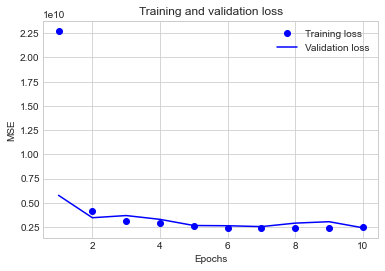

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()

plt.show()

In [11]:
preds = model.predict(X_test)

In [12]:
# metrics = get_metrics(y_test, np.expm1(preds))
metrics = get_metrics(y_test, preds)

MAE:  32293
RMSE: 48259
MAPE: 83.34%
R^2:  0.877
